In [4]:
# Hack to always autoreload modules and avoid restarting the kernel each time

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

In [9]:
import torchvision
from matplotlib import pyplot as plt

In [10]:
dataset = torchvision.datasets.CIFAR10(root="./data", download=True, train=True)

Files already downloaded and verified


## Visualizing Images Generated Using Different Hyperparameters

In [104]:
from data import CIFAR10GaussianSplatsDataset

gs_dataset_grid = CIFAR10GaussianSplatsDataset(root="../data/CIFAR10GS/CIFAR10GS/", train=True, init_type="grid")
gs_dataset_knn = CIFAR10GaussianSplatsDataset(root="../data/CIFAR10GS/CIFAR10GS/", train=True, init_type="knn")

# Each element in the grid is a tuple (image, label, splat_params)
gs_dataset_grid[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 1,
 ParameterDict(
     (Ks): Parameter containing: [torch.FloatTensor of size 3x3]
     (means): Parameter containing: [torch.FloatTensor of size 1024x3]
     (opacities): Parameter containing: [torch.FloatTensor of size 1024]
     (quats): Parameter containing: [torch.FloatTensor of size 1024x4]
     (scales): Parameter containing: [torch.FloatTensor of size 1024x3]
     (viewmats): Parameter containing: [torch.FloatTensor of size 4x4]
     (colors): Parameter containing: [torch.FloatTensor of size 1024x4x3]
 ))

In [108]:
gs_dataset_knn[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 1,
 ParameterDict(
     (Ks): Parameter containing: [torch.FloatTensor of size 3x3]
     (means): Parameter containing: [torch.FloatTensor of size 1024x3]
     (opacities): Parameter containing: [torch.FloatTensor of size 1024]
     (quats): Parameter containing: [torch.FloatTensor of size 1024x4]
     (scales): Parameter containing: [torch.DoubleTensor of size 1024x3]
     (viewmats): Parameter containing: [torch.FloatTensor of size 4x4]
     (colors): Parameter containing: [torch.FloatTensor of size 1024x4x3]
 ))

In [109]:
import torch

def get_attributes(splat):
    Ks = splat['Ks'].unsqueeze(0)  # Shape becomes (1, 3, 3)
    means = splat['means']
    opacities = torch.sigmoid(splat['opacities'])  # Normalize to [0, 1]
    quats = splat['quats']
    scales = splat['scales'].to(torch.float)  # Convert to float as this was a double for knn dataset
    viewmats = splat['viewmats'].unsqueeze(0)  # Shape becomes (1, 4, 4)
    colors = splat['colors']
    return Ks, means, opacities, quats, scales, viewmats, colors

In [110]:
import torch
from gsplat.rendering import rasterization, rasterization_2dgs
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def render_splat_image(splat):
    splat = splat.to(device)
    Ks, means, opacities, quats, scales, viewmats, colors = get_attributes(splat)

    rgbs, alphas, meta, normals, surf_normals, distort, median_depth = rasterization_2dgs(
        means, quats, scales, opacities, colors, viewmats, Ks, 32, 32, sh_degree=1
    )
    
    return rgbs, alphas, normals, surf_normals, distort, median_depth, meta

In [111]:
def get_splat_image(splat):
    rgbs, alphas, normals, surf_normals, distort, median_depth, meta = render_splat_image(splat)
    img = (rgbs[0].detach().cpu().numpy() * 255).astype(np.uint8)
    return img

In [112]:
selected_indices = [None] * 10  # Initialize with 10 None values
found_labels = set()

# Find first occurrence of each label 0-9 and store in correct position
i = 0
while len(found_labels) < 10 and i < len(gs_dataset_grid):
    _, label, _ = gs_dataset_grid[i]
    if label not in found_labels:
        selected_indices[label] = i  # Store index at position corresponding to label
        found_labels.add(label)
    i += 1

# Remove any None values (though there shouldn't be any if dataset is complete)
selected_indices = [idx for idx in selected_indices if idx is not None]


In [113]:
len(selected_indices)

10

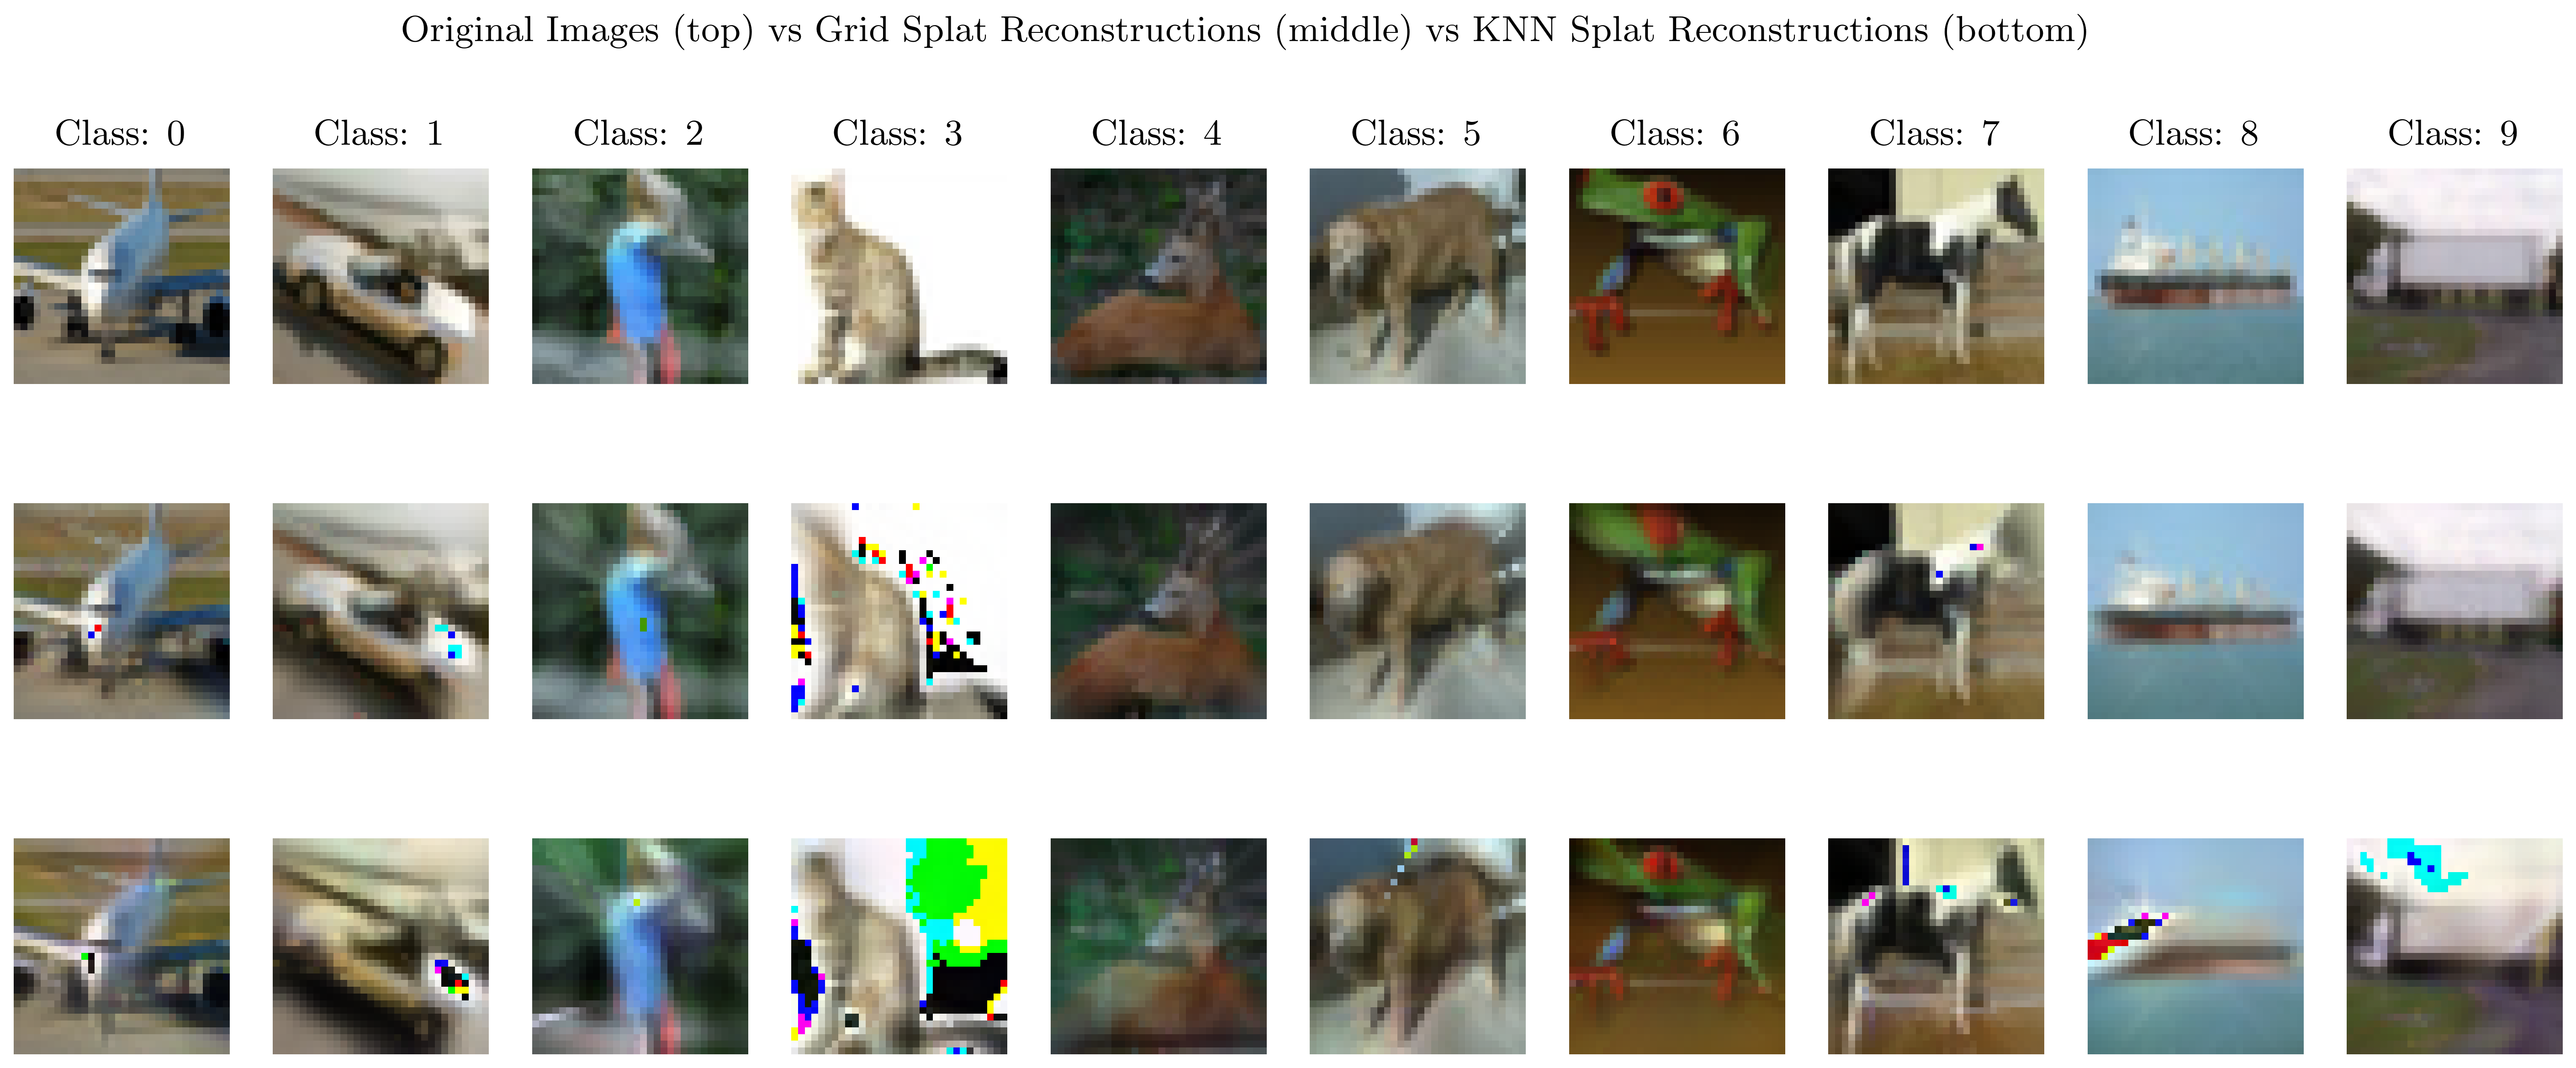

In [114]:
plt.style.use('../style/main.mpltstyle')

# Create a figure with 3 rows and 10 columns for better visibility
fig, axes = plt.subplots(3, 10, figsize=(12, 4.5))
fig.suptitle('Original Images (top) vs Grid Splat Reconstructions (middle) vs KNN Splat Reconstructions (bottom)')
# fig.tight_layout(pad=1.0)

for i, img_idx in enumerate(selected_indices):
    # Get the image and splat parameters from grid dataset
    img, label, splat_params_grid = gs_dataset_grid[img_idx]
    
    # Get corresponding splat parameters from knn dataset
    _, _, splat_params_knn = gs_dataset_knn[img_idx]
    
    # Plot original images in top row
    axes[0,i].imshow(img)
    axes[0,i].set_title(f'Class: {label}')
    axes[0,i].axis('off')
    
    # Plot grid splat visualizations in middle row
    splat_img_grid = get_splat_image(splat_params_grid)
    axes[1,i].imshow(splat_img_grid)
    axes[1,i].axis('off')
    
    # Plot knn splat visualizations in bottom row
    splat_img_knn = get_splat_image(splat_params_knn)
    axes[2,i].imshow(splat_img_knn)
    axes[2,i].axis('off')

plt.show()


In [115]:
gs_dataset_grid.class_to_index

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
gs_dataset_knn